<a href="https://colab.research.google.com/github/ProjectProRepo/Data-Mining-Projects/blob/main/FakeNewsDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fake-and-real-news-dataset


Import libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [10]:
import os
import pandas as pd

 Load the dataset

In [11]:
fake_df = pd.read_csv(os.path.join(path,"Fake.csv"))

In [12]:
real_df = pd.read_csv(os.path.join(path,"True.csv"))

In [13]:
# Add labels
fake_df['label'] = 0   # Fake
real_df['label'] = 1   # Real

In [18]:
fake_df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [17]:
real_df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [16]:
df = pd.concat([fake_df, real_df], axis=0).reset_index(drop=True)
print(df.shape)
df.head()

(44898, 5)


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


Data cleaning


In [21]:
df = df.drop(columns = ['subject','date'], errors = 'ignore')
df.head()

,title,text,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0


In [22]:
def clean_text(text):
  text = text.lower()
  text = re.sub(r'\[.*\]','',text)
  text = re.sub(r'https?://\S+|www\.\S+','',text)
  text = re.sub(r'<.*?>+','',text)
  text = re.sub(r'[%s]' % re.escape(string.punctuation),'',text)
  text = re.sub(r'\n','',text)
  text = re.sub(r'\w*\d\w*','',text)
  return text

df['text'] = df['text'].apply(clean_text)
df['title'] = df['title'].apply(clean_text)
df['content'] = df['title'] + " " + df['text']

df.head()

,title,text,label,content
0,donald trump sends out embarrassing new year’...,donald trump just couldn t wish all americans ...,0,donald trump sends out embarrassing new year’...
1,drunk bragging trump staffer started russian ...,house intelligence committee chairman devin nu...,0,drunk bragging trump staffer started russian ...
2,sheriff david clarke becomes an internet joke...,on friday it was revealed that former milwauke...,0,sheriff david clarke becomes an internet joke...
3,trump is so obsessed he even has obama’s name...,on christmas day donald trump announced that h...,0,trump is so obsessed he even has obama’s name...
4,pope francis just called out donald trump dur...,pope francis used his annual christmas day mes...,0,pope francis just called out donald trump dur...


# Exploratory Data Analysis (EDA)

1. Fake vs Real News Distribution

/tmp/ipython-input-2409501498.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='Set2')


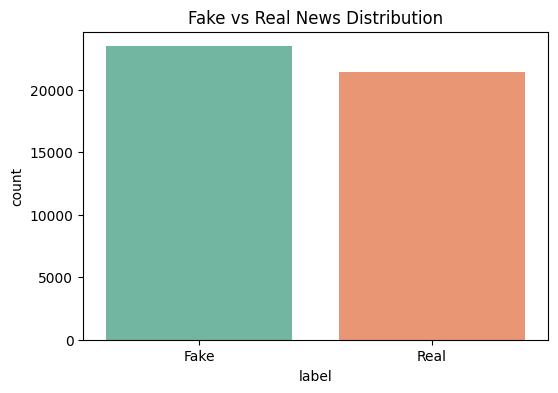

In [23]:
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df, palette='Set2')
plt.xticks([0,1], ['Fake', 'Real'])
plt.title("Fake vs Real News Distribution")
plt.show()

2. Word Count Analysis

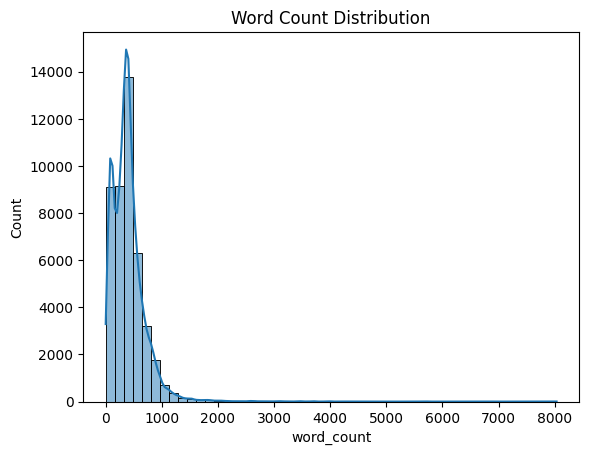

In [24]:
df['word_count'] = df['content'].apply(lambda x: len(x.split()))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title("Word Count Distribution")
plt.show()

3. Top 20 Most Frequent Words in Fake vs Real News

In [29]:
from collections import Counter
from wordcloud import WordCloud

fake_news = " ".join(df[df['label'] ==0]['content'])
real_news = " ".join(df[df['label']==1]['content'])

fake_words = Counter(fake_news.split()).most_common(20)
real_words = Counter(real_news.split()).most_common(20)

# Convert to DataFrame for plotting
fake_df_wc = pd.DataFrame(fake_words, columns=['word','count'])
real_df_wc = pd.DataFrame(real_words, columns=['word','count'])

In [31]:
fake_df_wc.head()


,word,count
0,the,516759
1,to,291554
2,of,233647
3,and,221164
4,a,208445


/tmp/ipython-input-1011494170.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="word", data=fake_df_wc, ax=axes[0], palette="Reds")
/tmp/ipython-input-1011494170.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="word", data=real_df_wc, ax=axes[1], palette="Greens")


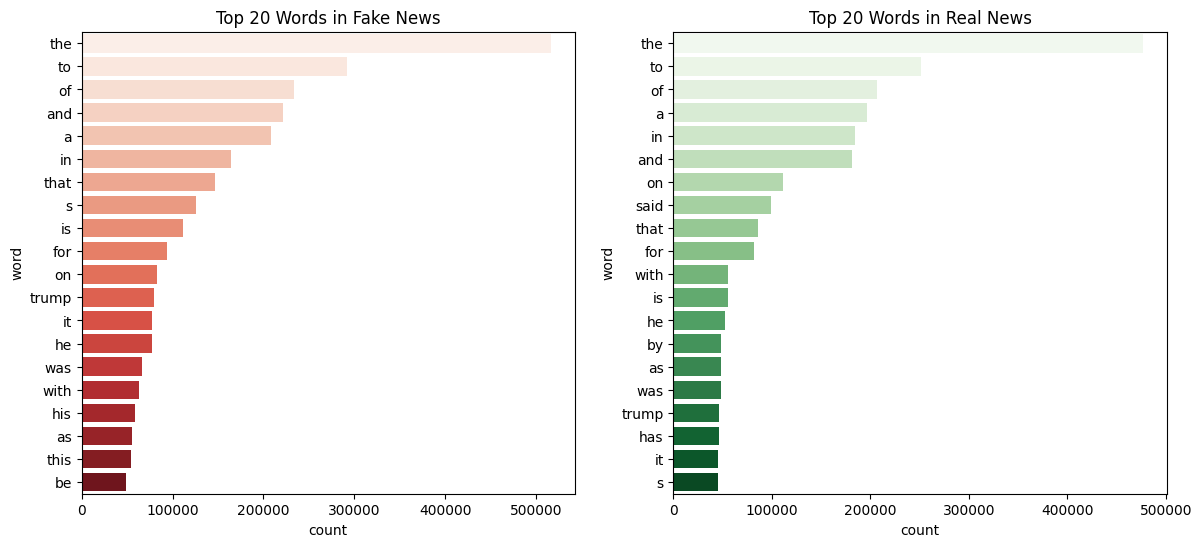

In [32]:
fig, axes = plt.subplots(1,2, figsize=(14,6))
sns.barplot(x="count", y="word", data=fake_df_wc, ax=axes[0], palette="Reds")
axes[0].set_title("Top 20 Words in Fake News")
sns.barplot(x="count", y="word", data=real_df_wc, ax=axes[1], palette="Greens")
axes[1].set_title("Top 20 Words in Real News")
plt.show()

Removing Stopwords

In [34]:
import nltk
from nltk.corpus import stopwords
from collections import Counter

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [35]:
# Create a set of English stopwords for fast lookup
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove words that are just spaces or empty strings
    words = [word for word in text.split() if word.isalpha()]
    # Remove stop words
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

# Assuming df is your DataFrame
# Split fake and real news
fake_news = " ".join(df[df['label']==0]['content'])
real_news = " ".join(df[df['label']==1]['content'])

# Preprocess the text
processed_fake_news = preprocess_text(fake_news)
processed_real_news = preprocess_text(real_news)

# Word frequency after preprocessing
fake_words = Counter(processed_fake_news.split()).most_common(20)
real_words = Counter(processed_real_news.split()).most_common(20)

print("Top 20 words in fake news (after removing stop words):")
print(fake_words)
print("\nTop 20 words in real news (after removing stop words):")
print(real_words)

Top 20 words in fake news (after removing stop words):
[('trump', 79802), ('said', 30534), ('president', 26119), ('people', 25796), ('would', 23065), ('one', 22848), ('us', 22273), ('obama', 19213), ('clinton', 18466), ('donald', 17758), ('like', 17636), ('hillary', 15014), ('also', 14753), ('new', 14617), ('news', 14560), ('even', 13518), ('white', 13273), ('time', 12621), ('state', 12474), ('media', 11272)]

Top 20 words in real news (after removing stop words):
[('said', 98841), ('trump', 46705), ('us', 44735), ('would', 31580), ('reuters', 28320), ('president', 25623), ('state', 19108), ('government', 18205), ('house', 17696), ('new', 17528), ('states', 16175), ('also', 15902), ('republican', 15879), ('united', 15558), ('people', 14625), ('told', 14251), ('could', 13841), ('last', 12615), ('one', 12357), ('washington', 12186)]


In [36]:
# Create dataframes for plotting
fake_df_wc = pd.DataFrame(fake_words, columns=['word', 'count'])
real_df_wc = pd.DataFrame(real_words, columns=['word', 'count'])



/tmp/ipython-input-1011494170.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="word", data=fake_df_wc, ax=axes[0], palette="Reds")
/tmp/ipython-input-1011494170.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="word", data=real_df_wc, ax=axes[1], palette="Greens")


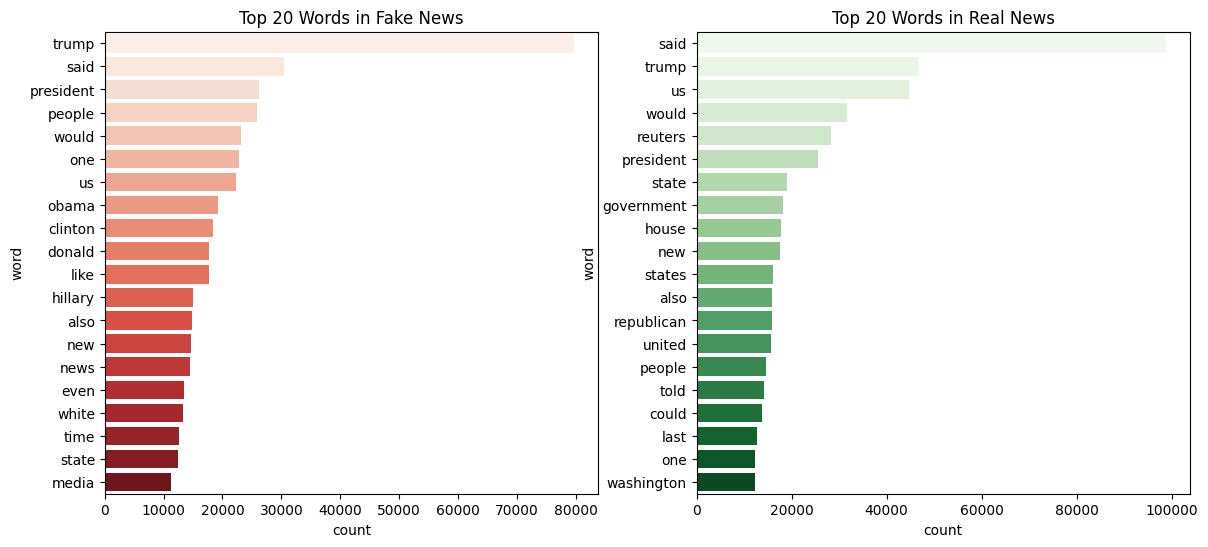

In [37]:
fig, axes = plt.subplots(1,2, figsize=(14,6))
sns.barplot(x="count", y="word", data=fake_df_wc, ax=axes[0], palette="Reds")
axes[0].set_title("Top 20 Words in Fake News")
sns.barplot(x="count", y="word", data=real_df_wc, ax=axes[1], palette="Greens")
axes[1].set_title("Top 20 Words in Real News")
plt.show()

4. Word Clouds for Fake vs Real News

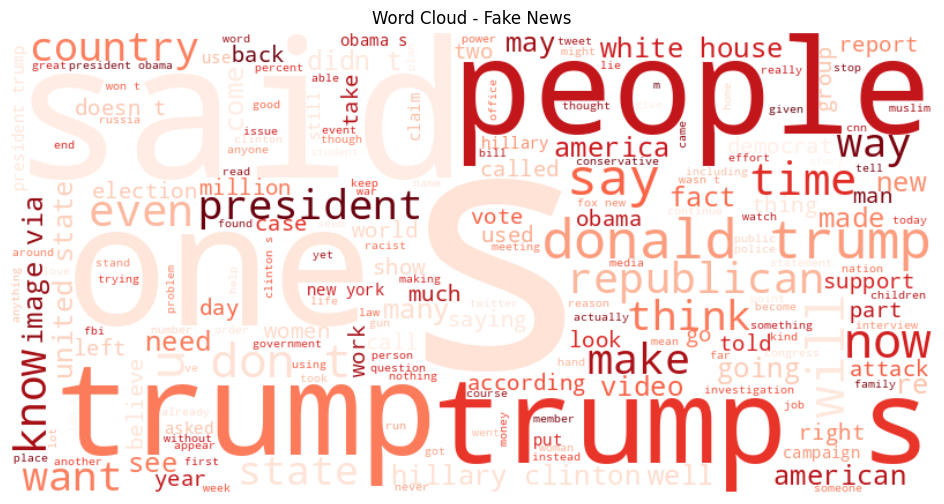

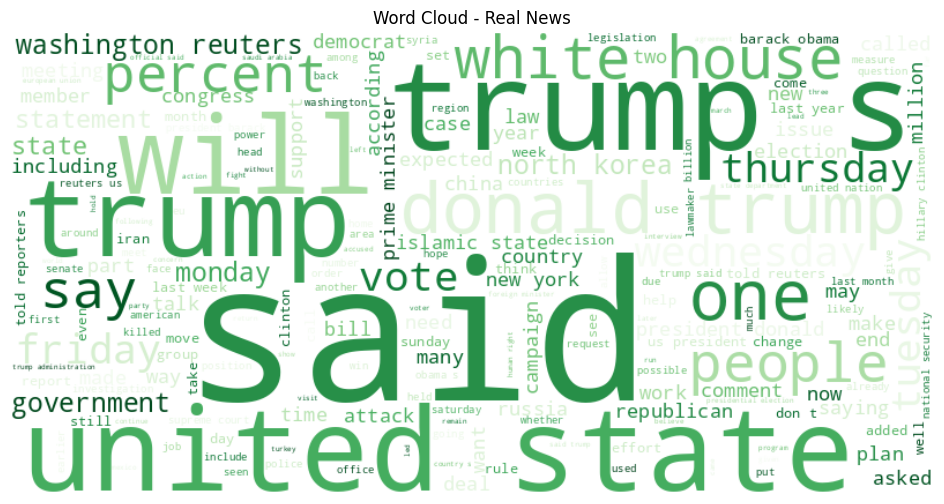

In [38]:
# Fake news wordcloud
plt.figure(figsize=(12,6))
wc_fake = WordCloud(width=800, height=400, background_color='white', colormap="Reds").generate(fake_news)
plt.imshow(wc_fake, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Fake News")
plt.show()

# Real news wordcloud
plt.figure(figsize=(12,6))
wc_real = WordCloud(width=800, height=400, background_color='white', colormap="Greens").generate(real_news)
plt.imshow(wc_real, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Real News")
plt.show()

5. Distribution of Article Lengths

/tmp/ipython-input-3779938358.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['label']==0]['word_count'], shade=True, color="red", label="Fake")
/tmp/ipython-input-3779938358.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['label']==1]['word_count'], shade=True, color="green", label="Real")


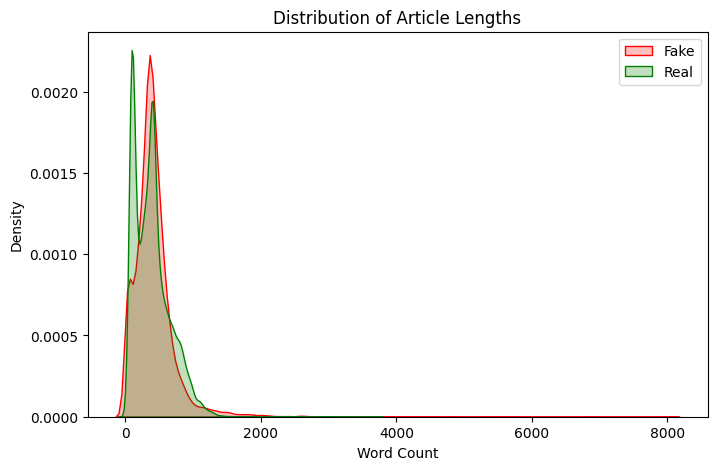

In [39]:
plt.figure(figsize=(8,5))
sns.kdeplot(df[df['label']==0]['word_count'], shade=True, color="red", label="Fake")
sns.kdeplot(df[df['label']==1]['word_count'], shade=True, color="green", label="Real")
plt.title("Distribution of Article Lengths")
plt.xlabel("Word Count")
plt.ylabel("Density")
plt.legend()
plt.show()


6. Title vs Text Word Count

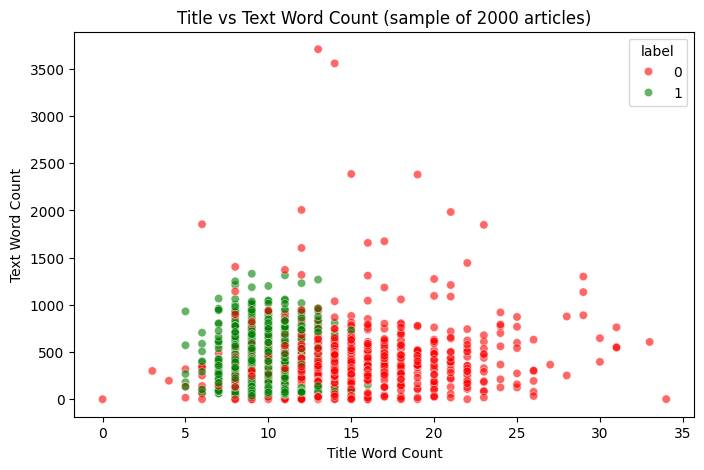

In [40]:
df['title_word_count'] = df['title'].apply(lambda x: len(x.split()))
df['text_word_count'] = df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,5))
sns.scatterplot(x="title_word_count", y="text_word_count", hue="label",
                data=df.sample(2000), palette={0:"red",1:"green"}, alpha=0.6)
plt.title("Title vs Text Word Count (sample of 2000 articles)")
plt.xlabel("Title Word Count")
plt.ylabel("Text Word Count")
plt.show()


7. Most Common Subjects (if we keep the subject column)

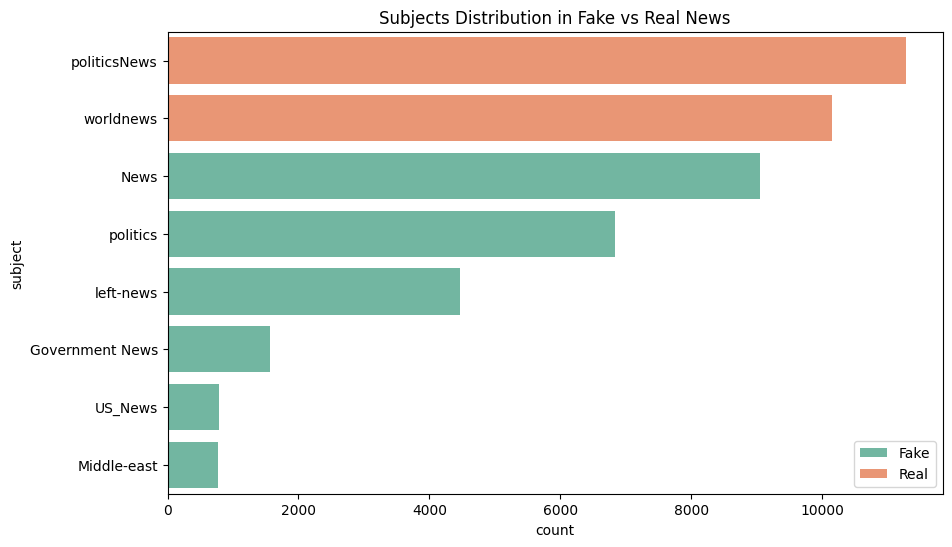

In [42]:
# Reload with subject column if not dropped
df_subject = pd.concat([fake_df, real_df], axis=0)

plt.figure(figsize=(10,6))
sns.countplot(y="subject", hue="label", data=df_subject, palette="Set2", order=df_subject['subject'].value_counts().index)
plt.title("Subjects Distribution in Fake vs Real News")
plt.legend(labels=["Fake","Real"])
plt.show()
